<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Break_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai

In [2]:
import os
from google.colab import userdata
from IPython.display import Image, display

In [3]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

In [4]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [5]:
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')

## Utils Funtions

In [15]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=300):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

#### Tools

In [7]:
def sum(a:float, b:float) -> float:
  """Sum a and b

  Args:
    a: first number
    b: second number"""
  return a+b

def minus(a:float, b:float) -> float:
  """Minus a and b

  Args:
    a: first number
    b: second number"""
  return a-b

def multiply(a:float, b:float) -> float:
  """Multiply a and b

  Args:
    a: first number
    b: second number"""
  return a*b

def divide(a:float, b:float) -> float:
  """Divide a and b

  Args:
    a: first number
    b: second number"""
  return a/b if b != 0 else "We cannot divide by zero"

#### Model binding

__“binding”__ tools refers to the process of connecting or associating specific tools or functions with the model so that it can use them during its operations.

In [16]:
llm = get_model()
llm_with_tools = llm.bind_tools(
    tools=[sum, minus, multiply, divide]
)

In [17]:
# System Message
sys_msg = SystemMessage(content="You are a helpful math tutor. Guide the user through the solution step by step.")

def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

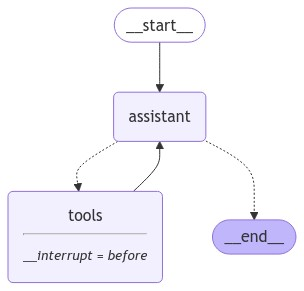

In [18]:
# Build Graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([sum, minus, multiply, divide]))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition) # If latest message is a tool Call -> routes Tool else routes END
builder.add_edge("tools", "assistant")

# Add Memory
memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

#View graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Input
initial_input = {"messages": "Multiply 0.6 by 0.77"}

# Thread
thread = {"configurable": {"thread_id": 2}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
  event["messages"][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to continue? (y/n)")

# Check approval
if user_approval.lower().strip() in ["y", "yes"]:

   # If approved, continue the execution
   for event in graph.stream(None, thread, stream_mode="values"):
      event["messages"][-1].pretty_print()

else:
  print("Exiting the graph")

================================ Human Message =================================

Multiply 0.6 by 0.77
================================== Ai Message ==================================
Tool Calls:
  multiply (call_WLVlDYpcvrN6SUpn7AQEb4Kt)
 Call ID: call_WLVlDYpcvrN6SUpn7AQEb4Kt
  Args:
    a: 0.6
    b: 0.77
Do you want to continue? (y/n)  y
================================== Ai Message ==================================
Tool Calls:
  multiply (call_WLVlDYpcvrN6SUpn7AQEb4Kt)
 Call ID: call_WLVlDYpcvrN6SUpn7AQEb4Kt
  Args:
    a: 0.6
    b: 0.77
================================= Tool Message =================================
Name: multiply

0.46199999999999997
================================== Ai Message ==================================

The result of multiplying \(0.6\) by \(0.77\) is approximately \(0.462\).


In [12]:
# Input
initial_input = {"messages": "Multiply 0.8 by 0.112"}

# Thread
thread = {"configurable": {"thread_id": 2}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
  event["messages"][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to continue? (y/n)")

# Check approval
if user_approval.lower().strip() in ["y", "yes"]:

   # If approved, continue the execution
   for event in graph.stream(None, thread, stream_mode="values"):
      event["messages"][-1].pretty_print()

else:
  print("Exiting the graph")

================================ Human Message =================================

Multiply 0.8 by 0.112
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zdJdKVEMpxaQjuIfaHRw85ka)
 Call ID: call_zdJdKVEMpxaQjuIfaHRw85ka
  Args:
    a: 0.8
    b: 0.112
Do you want to continue? (y/n)no
Exiting the graph


In [19]:
# Input
initial_input = {"messages": "Multiply 0.6 by 0.77. Then add 0.534. And finally divide by 0.001"}

# Thread
thread = {"configurable": {"thread_id": 121}}

initial = True
while initial or state.next:

  input_val = initial_input if initial else None
  for event in graph.stream(input_val, thread, stream_mode="values"):
      event["messages"][-1].pretty_print()
  state = graph.get_state(thread)
  # Get user feedback
  if state.next:
    user_approval = input("Do you want to continue? (y/n)")

  # Check approval
  if user_approval.lower().strip() in ["y", "yes"]:
    initial = False
    continue
  else:
    print("Exiting the graph")
    break

================================ Human Message =================================

Multiply 0.6 by 0.77. Then add 0.534. And finally divide by 0.001
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2K0NTrO0ZBlzoJ6mAqG1VyUH)
 Call ID: call_2K0NTrO0ZBlzoJ6mAqG1VyUH
  Args:
    a: 0.6
    b: 0.77
Do you want to continue? (y/n) yes
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2K0NTrO0ZBlzoJ6mAqG1VyUH)
 Call ID: call_2K0NTrO0ZBlzoJ6mAqG1VyUH
  Args:
    a: 0.6
    b: 0.77
================================= Tool Message =================================
Name: multiply

0.46199999999999997
================================== Ai Message ==================================
Tool Calls:
  sum (call_qtCfr2s1ESQgAXwkq2Dr9XO7)
 Call ID: call_qtCfr2s1ESQgAXwkq2Dr9XO7
  Args:
    a: 0.46199999999999997
    b: 0.534
Do you want to continue? (y/n)   y
================================

In [20]:
# Input
initial_input = {"messages": "Multiply 0.23 by 0.41. Then add 0.138. And finally divide by 0.01"}

# Thread
thread = {"configurable": {"thread_id": 121}}

initial = True
while initial or state.next:

  input_val = initial_input if initial else None
  for event in graph.stream(input_val, thread, stream_mode="values"):
      event["messages"][-1].pretty_print()
  state = graph.get_state(thread)
  # Get user feedback
  if state.next:
    user_approval = input("Do you want to continue? (y/n)")

  # Check approval
  if user_approval.lower().strip() in ["y", "yes"]:
    initial = False
    continue
  else:
    print("Exiting the graph")
    break

================================ Human Message =================================

Multiply 0.23 by 0.41. Then add 0.138. And finally divide by 0.01
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4cpHWu4uYpRjSkqdOjfljfKO)
 Call ID: call_4cpHWu4uYpRjSkqdOjfljfKO
  Args:
    a: 0.23
    b: 0.41
Do you want to continue? (y/n)yes
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4cpHWu4uYpRjSkqdOjfljfKO)
 Call ID: call_4cpHWu4uYpRjSkqdOjfljfKO
  Args:
    a: 0.23
    b: 0.41
================================= Tool Message =================================
Name: multiply

0.0943
================================== Ai Message ==================================
Tool Calls:
  sum (call_WLVlDYpcvrN6SUpn7AQEb4Kt)
 Call ID: call_WLVlDYpcvrN6SUpn7AQEb4Kt
  Args:
    a: 0.0943
    b: 0.138
Do you want to continue? (y/n)y
================================== Ai Message ==============